In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from keras.models import load_model

In [ ]:
from keras import backend as K

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
reconstructed_model = load_model("/content/gdrive/MyDrive/Colab Notebooks/sentimentModel", 
                                 custom_objects={'precision_m':precision_m})

In [ ]:
import pandas as pd
df1 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Tweets.csv")
df1
df2 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/TweetsTest.csv")
df2

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,10003814,Negative,1,NaN,NaN,NaN,NaN,cairdin,NaN,0,Worst service,NaN,24/2/2015 11:35,NaN,Eastern Time (US & Canada)
1,10003814,Neutral,1,NaN,NaN,NaN,NaN,cairdin,NaN,0,My name is Ashek,NaN,24/2/2015 11:35,NaN,Eastern Time (US & Canada)
2,10003814,Neutral,1,NaN,NaN,NaN,NaN,cairdin,NaN,0,Service is ok.,NaN,24/2/2015 11:35,NaN,Eastern Time (US & Canada)
3,10003814,Positive,1,NaN,NaN,NaN,NaN,cairdin,NaN,0,Great service,NaN,24/2/2015 11:35,NaN,Eastern Time (US & Canada)


In [ ]:
df = pd.concat([df1, df2])
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN
0,10003814,Negative,1.0000,NaN,NaN,NaN,NaN,cairdin,NaN,0,Worst service,NaN,24/2/2015 11:35,NaN,Eastern Time (US & Canada)
1,10003814,Neutral,1.0000,NaN,NaN,NaN,NaN,cairdin,NaN,0,My name is Ashek,NaN,24/2/2015 11:35,NaN,Eastern Time (US & Canada)
2,10003814,Neutral,1.0000,NaN,NaN,NaN,NaN,cairdin,NaN,0,Service is ok.,NaN,24/2/2015 11:35,NaN,Eastern Time (US & Canada)


In [ ]:
df=df[['tweet_id', 'text', 'airline','airline_sentiment', 'negativereason']]
df

,tweet_id,text,airline,airline_sentiment,negativereason
0,570306133677760513,@VirginAmerica What @dhepburn said.,Virgin America,neutral,NaN
1,570301130888122368,@VirginAmerica plus you've added commercials t...,Virgin America,positive,NaN
2,570301083672813571,@VirginAmerica I didn't today... Must mean I n...,Virgin America,neutral,NaN
3,570301031407624196,@VirginAmerica it's really aggressive to blast...,Virgin America,negative,Bad Flight
4,570300817074462722,@VirginAmerica and it's a really big bad thing...,Virgin America,negative,Can't Tell
...,...,...,...,...,...
14639,569587140490866689,@AmericanAir we have 8 ppl so we need 2 know h...,American,neutral,NaN
0,10003814,Worst service,NaN,Negative,NaN
1,10003814,My name is Ashek,NaN,Neutral,NaN
2,10003814,Service is ok.,NaN,Neutral,NaN


In [ ]:
airline = pd.get_dummies(df['airline'])
user_negativereason = pd.get_dummies(df['negativereason'])

df = pd.concat([df, airline, user_negativereason], axis = 1)
df

,tweet_id,text,airline,airline_sentiment,negativereason,American,Delta,Southwest,US Airways,United,Virgin America,Bad Flight,Can't Tell,Cancelled Flight,Customer Service Issue,Damaged Luggage,Flight Attendant Complaints,Flight Booking Problems,Late Flight,Lost Luggage,longlines
0,570306133677760513,@VirginAmerica What @dhepburn said.,Virgin America,neutral,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,570301130888122368,@VirginAmerica plus you've added commercials t...,Virgin America,positive,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,570301083672813571,@VirginAmerica I didn't today... Must mean I n...,Virgin America,neutral,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,570301031407624196,@VirginAmerica it's really aggressive to blast...,Virgin America,negative,Bad Flight,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
4,570300817074462722,@VirginAmerica and it's a really big bad thing...,Virgin America,negative,Can't Tell,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14639,569587140490866689,@AmericanAir we have 8 ppl so we need 2 know h...,American,neutral,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,10003814,Worst service,NaN,Negative,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10003814,My name is Ashek,NaN,Neutral,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10003814,Service is ok.,NaN,Neutral,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
negativereason = list(user_negativereason.columns)
airline = list(airline.columns)
airline_negativeReason = airline+negativereason
print(airline_negativeReason)

['American', 'Delta', 'Southwest', 'US Airways', 'United', 'Virgin America', 'Bad Flight', "Can't Tell", 'Cancelled Flight', 'Customer Service Issue', 'Damaged Luggage', 'Flight Attendant Complaints', 'Flight Booking Problems', 'Late Flight', 'Lost Luggage', 'longlines']


In [ ]:
import numpy as np
import re

def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt) 
  return input_txt

In [ ]:
# small letter
df['text_clean'] = df['text'].str.lower()

#  Removing Twitter Handles (@user) 
df['text_clean'] = np.vectorize(remove_pattern)(df['text_clean'], r"@[\w]*")

In [ ]:
# Removing URL
df['text_clean'] = np.vectorize(remove_pattern)(df['text_clean'], r'^http?:\/\/.*[\r\n]*')
df['text_clean'] = np.vectorize(remove_pattern)(df['text_clean'], r'^https?:\/\/.*[\r\n]*') 

In [ ]:
# Removing Punctuations, Numbers, and Special Characters
df['text_clean'] = df['text_clean'].str.replace("[^a-zA-Z#]", " ")
#df

In [ ]:
# tokenize

from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()
df['text_tokenize'] = df['text_clean'].apply(tt.tokenize)


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

stop_words = [i for i in stop_words if "'t" not in i and "not" not in i]
df['text_stopwords'] = df['text_tokenize'].apply(lambda x: [item for item in x if item not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def to_char(test_list):
  return  [ele for ele in test_list if ele is not ' ']

df['text_char'] = df['text_clean'].apply(to_char)
#df['text_char']

In [ ]:
df['word_count'] = df['text_tokenize'].str.len()
df['char_count'] = df['text_char'].str.len()
df.head()

,tweet_id,text,airline,airline_sentiment,negativereason,American,Delta,Southwest,US Airways,United,Virgin America,Bad Flight,Can't Tell,Cancelled Flight,Customer Service Issue,Damaged Luggage,Flight Attendant Complaints,Flight Booking Problems,Late Flight,Lost Luggage,longlines,text_clean,text_tokenize,text_stopwords,text_char,word_count,char_count
0,570306133677760513,@VirginAmerica What @dhepburn said.,Virgin America,neutral,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,what said,"[what, said]",[said],"[w, h, a, t, s, a, i, d]",2,8
1,570301130888122368,@VirginAmerica plus you've added commercials t...,Virgin America,positive,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,plus you ve added commercials to the experien...,"[plus, you, ve, added, commercials, to, the, e...","[plus, added, commercials, experience, tacky]","[p, l, u, s, y, o, u, v, e, a, d, d, e, d, c, ...",9,45
2,570301083672813571,@VirginAmerica I didn't today... Must mean I n...,Virgin America,neutral,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,i didn t today must mean i need to take an...,"[i, didn, t, today, must, mean, i, need, to, t...","[today, must, mean, need, take, another, trip]","[i, d, i, d, n, t, t, o, d, a, y, m, u, s, t, ...",12,41
3,570301031407624196,@VirginAmerica it's really aggressive to blast...,Virgin America,negative,Bad Flight,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,it s really aggressive to blast obnoxious en...,"[it, s, really, aggressive, to, blast, obnoxio...","[really, aggressive, blast, obnoxious, enterta...","[i, t, s, r, e, a, l, l, y, a, g, g, r, e, s, ...",17,90
4,570300817074462722,@VirginAmerica and it's a really big bad thing...,Virgin America,negative,Can't Tell,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,and it s a really big bad thing about it,"[and, it, s, a, really, big, bad, thing, about...","[really, big, bad, thing]","[a, n, d, i, t, s, a, r, e, a, l, l, y, b, i, ...",10,31


In [ ]:
max = 0
total_unique = 0
all_text = []

for twitte in df['text_stopwords']:
  if len(twitte)>max:
    max = len(twitte)
  all_text.extend(twitte)

all_text = set(all_text)
vocab_size = len(all_text)
print(f'max word count of clean text: {max}\ntotal unique words after cleaning: {vocab_size}')

# change vocab size
# vocab_size = 10000

max word count of clean text: 23
total unique words after cleaning: 13211


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = vocab_size
max_len = max

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['text_stopwords'].values)

#len(tokenizer.index_word )
#tokenizer

In [ ]:
max_char = 0
all_char = []
for i in df['text_clean']:
  if len(i)>max_char:
    max_char = len(i)
  all_char.extend(set(i))

char_vocab_size = len(set(all_char))

print(f'max vocab for char apporach {char_vocab_size}\nmax char {max_char}')

max vocab for char apporach 28
max char 176


In [ ]:
from keras.preprocessing.text import Tokenizer

max_words2 = char_vocab_size
max_len2 = max_char

tokenizer2 = Tokenizer(num_words=max_words2)
tokenizer2.fit_on_texts(df['text_char'].values)


In [ ]:
all = airline_negativeReason+['word_count','char_count']
print (all)
len(all)

['American', 'Delta', 'Southwest', 'US Airways', 'United', 'Virgin America', 'Bad Flight', "Can't Tell", 'Cancelled Flight', 'Customer Service Issue', 'Damaged Luggage', 'Flight Attendant Complaints', 'Flight Booking Problems', 'Late Flight', 'Lost Luggage', 'longlines', 'word_count', 'char_count']


18

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(stop_words=stop_words,max_features=1000)
x = v.fit_transform(df['text_clean'])
print(x)
print(x.size)
type(x)

#x[trainX.index].toarray()
#trainX.index

  (0, 747)	1.0
  (1, 290)	0.4696998885057248
  (1, 10)	0.6690474362634387
  (1, 666)	0.5759839778735427
  (2, 896)	0.3639741478710706
  (2, 37)	0.34635864977842856
  (2, 844)	0.3471406691847481
  (2, 586)	0.2981286110889503
  (2, 543)	0.45322943358117823
  (2, 582)	0.4831365106547793
  (2, 878)	0.31517199282509084
  (3, 506)	0.5469466300770953
  (3, 35)	0.35793632926378566
  (3, 272)	0.6294657764434457
  (3, 700)	0.4201235584050553
  (4, 862)	0.5490716443515375
  (4, 80)	0.4683677994443001
  (4, 92)	0.5466616979631921
  (4, 700)	0.4246326904429311
  (5, 341)	0.3124990952765417
  (5, 760)	0.343016296118494
  (5, 326)	0.15861093983518076
  (5, 642)	0.3676936638433223
  (5, 987)	0.277687381281293
  (5, 773)	0.39967456607586865
  :	:
  (14638, 652)	0.538930578632129
  (14638, 531)	0.3660515252689503
  (14638, 573)	0.45540852238247576
  (14638, 38)	0.44565563633889377
  (14638, 140)	0.3677824535279548
  (14638, 326)	0.18517643122508087
  (14639, 689)	0.26362803777147076
  (14639, 676)	0.335

scipy.sparse.csr.csr_matrix

In [ ]:
df2 = df[df['tweet_id']==10003814]
df2

,tweet_id,text,airline,airline_sentiment,negativereason,American,Delta,Southwest,US Airways,United,Virgin America,Bad Flight,Can't Tell,Cancelled Flight,Customer Service Issue,Damaged Luggage,Flight Attendant Complaints,Flight Booking Problems,Late Flight,Lost Luggage,longlines,text_clean,text_tokenize,text_stopwords,text_char,word_count,char_count
0,10003814,Worst service,NaN,Negative,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,worst service,"[worst, service]","[worst, service]","[w, o, r, s, t, s, e, r, v, i, c, e]",2,12
1,10003814,My name is Ashek,NaN,Neutral,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,my name is ashek,"[my, name, is, ashek]","[name, ashek]","[m, y, n, a, m, e, i, s, a, s, h, e, k]",4,13
2,10003814,Service is ok.,NaN,Neutral,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,service is ok,"[service, is, ok]","[service, ok]","[s, e, r, v, i, c, e, i, s, o, k]",3,11
3,10003814,Great service,NaN,Positive,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,great service,"[great, service]","[great, service]","[g, r, e, a, t, s, e, r, v, i, c, e]",2,12


In [ ]:
testX = df2['text_stopwords']
testX

0    [worst, service]
1       [name, ashek]
2       [service, ok]
3    [great, service]
Name: text_stopwords, dtype: object

In [ ]:
testY = df2['airline_sentiment']
testY

0    Negative
1     Neutral
2     Neutral
3    Positive
Name: airline_sentiment, dtype: object

In [ ]:
trainY = df['airline_sentiment']

In [ ]:
testX2 = df.iloc[testX.index][all].values
testX2

array([[ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         2,  8],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         9, 45],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        12, 41],
       [ 0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        17, 90]])

In [ ]:
testX2 = np.hstack((testX2, x[testX.index].toarray()))
print(testX2.size)
print(testX2[0].size)

4072
1018


In [ ]:
testX = tokenizer.texts_to_sequences(testX)
testX = pad_sequences(testX, maxlen=max_len)
testX

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,  97,   8],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0, 247],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   8, 230],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,  47,   8]], dtype=int32)

In [ ]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(trainY)

print(lb.classes_)
print(testY)

trainY = lb.transform(trainY)
testY = lb.transform(testY)
print(testY)

['Negative' 'Neutral' 'Positive' 'negative' 'neutral' 'positive']
0    Negative
1     Neutral
2     Neutral
3    Positive
Name: airline_sentiment, dtype: object
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]]


In [ ]:
y_pred = reconstructed_model.predict([testX2, testX])
y_pred

array([[4.8451009e-04, 9.9730670e-01, 2.2088254e-03],
       [7.2065322e-04, 5.7623154e-01, 4.2304784e-01],
       [1.0163942e-03, 6.9586569e-01, 3.0311787e-01],
       [9.9998891e-01, 1.0482766e-05, 5.9541406e-07]], dtype=float32)

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax




In [ ]:
def convert_to_array_result(y):
  y_pred_array = np.zeros(y.shape[0])

  # Find class with highest probability
  for i in range(0, y.shape[0]):
      label_predict = np.argmax(y[i]) # column with max probability
      y_pred_array[i] = label_predict

  # convert to integers
  y_pred_array = y_pred_array.astype(int)
  return y_pred_array

Confusion matrix, without normalization
[[0 1 0]
 [0 2 0]
 [1 0 0]]


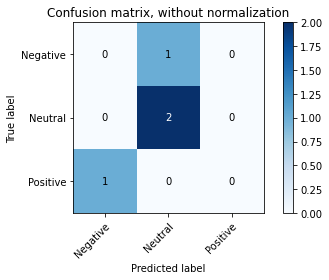

In [ ]:
classNames=np.array(['Negative', 'Neutral', 'Positive']);
plot_confusion_matrix(convert_to_array_result(testY), convert_to_array_result(y_pred), classes=classNames)
#print(testY.shape)
#print (y_pred.shape)
test=convert_to_array_result(testY)
#print(test)